In [ ]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import torch
from ultralytics import YOLO
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check for GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {DEVICE}")

# Define project structure
base_dir = Path.cwd()
img_dir = base_dir / "images"
label_dir = base_dir / "labels"
output_dir = base_dir  # Same local folder
yaml_path = base_dir / "data.yaml"

classes = ['helmet', 'vest', 'head']
num_classes = len(classes)

# Validate directories
for split in ['train', 'val', 'test']:
    img_split_dir = img_dir / split
    label_split_dir = label_dir / split
    if not img_split_dir.exists() or not label_split_dir.exists():
        logging.error(f"{split} directory for images or labels not found!")
        raise FileNotFoundError(f"Ensure 'images/{split}' and 'labels/{split}' directories exist in {base_dir}.")

# Train YOLOv8 model
weights_path = base_dir / "runs" / "train" / "helmet_vest_detection" / "weights" / "best.pt"

# Check if weights exist
if weights_path.exists():
    logging.info(f"Found existing weights at {weights_path}. Loading model...")
    model = YOLO(str(weights_path))
else:
    logging.info("Weights not found. Starting YOLOv8 model training...")
    model = YOLO("yolov8n.pt")
    results = model.train(
        data=str(yaml_path),
        epochs=20,
        imgsz=640,
        batch=16,
        name="helmet_vest_detection",
        project="runs/train",
        device=DEVICE
    )
    logging.info(f"Model training completed. Weights saved to {weights_path}")

2025-05-24 22:37:15,746 - INFO - Using device: cuda
2025-05-24 22:37:15,749 - INFO - Found existing weights at c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\runs\train\helmet_vest_detection\weights\best.pt. Loading model...


In [2]:
from matplotlib import pyplot as plt
import cv2
import logging
from pathlib import Path
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Define paths
test_img_dir = base_dir / "images" / "test"
test_label_dir = base_dir / "labels" / "test"
save_dir = base_dir / "predictions"
save_dir.mkdir(parents=True, exist_ok=True)

# Store all predictions and labels
y_true = []
y_pred = []

# Ensure test image directory exists
if not test_img_dir.exists():
    logging.error(f"Test image directory not found: {test_img_dir}")
else:
    # Collect and sort all image files
    test_images = sorted([
        f for f in os.listdir(test_img_dir)
        if f.endswith(('.png', '.jpg', '.jpeg'))
    ])

    logging.info(f"Found {len(test_images)} test images.")

    # Run prediction, save annotated images, and collect labels
    for img_name in test_images:
        img_path = test_img_dir / img_name
        label_file = test_label_dir / f"{img_name.rsplit('.', 1)[0]}.txt"

        # Predict
        results = model.predict(source=str(img_path), conf=0.25, save=False)

        for r in results:
            # Collect predicted classes
            pred_classes = r.boxes.cls.cpu().numpy().astype(int).tolist()

            # Read ground truth labels
            if label_file.exists():
                with open(label_file) as f:
                    true_classes = [int(line.strip().split()[0]) for line in f.readlines()]
            else:
                logging.warning(f"Label file missing for {img_name}")
                true_classes = []

            # Only add if counts match
            if len(true_classes) == len(pred_classes):
                y_true.extend(true_classes)
                y_pred.extend(pred_classes)
            else:
                logging.warning(
                    f"Label-prediction mismatch in {img_name}: "
                    f"{len(true_classes)} ground truth vs {len(pred_classes)} predicted"
                )

            # Save annotated image
            img_pred = r.plot()
            img_bgr = cv2.cvtColor(img_pred, cv2.COLOR_RGB2BGR)
            save_path = save_dir / img_name
            cv2.imwrite(str(save_path), img_bgr)

    logging.info(f"Saved all annotated images to: {save_dir}")

2025-05-24 22:37:18,255 - INFO - Found 2455 test images.



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000009.jpg: 640x640 2 helmets, 1 vest, 5.8ms
Speed: 6.0ms preprocess, 5.8ms inference, 208.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:20,765 - WARNING - Label-prediction mismatch in 000009.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000010.jpg: 640x640 5 helmets, 10 vests, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:20,795 - WARNING - Label-prediction mismatch in 000010.jpg: 8 ground truth vs 15 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000021.jpg: 640x640 4 helmets, 14.5ms
Speed: 2.5ms preprocess, 14.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:20,830 - WARNING - Label-prediction mismatch in 000021.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000022.jpg: 640x640 7 helmets, 1 vest, 10.8ms
Speed: 2.5ms preprocess, 10.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:20,859 - WARNING - Label-prediction mismatch in 000022.jpg: 7 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000034.jpg: 640x640 1 helmet, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000036.jpg: 640x640 3 helmets, 12.8ms
Speed: 2.6ms preprocess, 12.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:20,917 - WARNING - Label-prediction mismatch in 000036.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000056.jpg: 640x640 1 helmet, 7 heads, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:20,941 - WARNING - Label-prediction mismatch in 000056.jpg: 7 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000079.jpg: 640x640 1 helmet, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000097.jpg: 640x640 1 helmet, 5.7ms
Speed: 2.2ms preprocess, 5.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000104.jpg: 640x640 4 helmets, 1 vest, 1 head, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,016 - WARNING - Label-prediction mismatch in 000104.jpg: 5 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000138.jpg: 640x640 1 helmet, 1 vest, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 6.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,049 - WARNING - Label-prediction mismatch in 000138.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000142.jpg: 640x640 4 helmets, 12.1ms
Speed: 3.0ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000144.jpg: 640x640 1 helmet, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000145.jpg: 640x640 4 helmets, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,131 - WARNING - Label-prediction mismatch in 000145.jpg: 2 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000147.jpg: 640x640 2 helmets, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000153.jpg: 640x640 1 helmet, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,177 - WARNING - Label-prediction mismatch in 000153.jpg: 2 ground truth vs 1 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000164.jpg: 640x640 4 heads, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000170.jpg: 640x640 6 heads, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000179.jpg: 640x640 4 helmets, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,245 - WARNING - Label-prediction mismatch in 000179.jpg: 1 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000186.jpg: 640x640 18 helmets, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,274 - WARNING - Label-prediction mismatch in 000186.jpg: 17 ground truth vs 18 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000193.jpg: 640x640 6 heads, 13.5ms
Speed: 2.6ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000194.jpg: 640x640 5 helmets, 7 vests, 14.1ms
Speed: 2.5ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,342 - WARNING - Label-prediction mismatch in 000194.jpg: 5 ground truth vs 12 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000203.jpg: 640x640 2 helmets, 12.7ms
Speed: 2.4ms preprocess, 12.7ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000220.jpg: 640x640 10 heads, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000221.jpg: 640x640 1 vest, 8 heads, 11.3ms
Speed: 2.4ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,428 - WARNING - Label-prediction mismatch in 000221.jpg: 7 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000226.jpg: 640x640 3 helmets, 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,459 - WARNING - Label-prediction mismatch in 000226.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000236.jpg: 640x640 2 helmets, 4 heads, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,485 - WARNING - Label-prediction mismatch in 000236.jpg: 8 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000241.jpg: 640x640 4 helmets, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000242.jpg: 640x640 5 heads, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000277.jpg: 640x640 4 helmets, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,559 - WARNING - Label-prediction mismatch in 000277.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000307.jpg: 640x640 1 helmet, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000314.jpg: 640x640 3 helmets, 5.4ms
Speed: 2.2ms preprocess, 5.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000322.jpg: 640x640 2 helmets, 2 vests, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,628 - WARNING - Label-prediction mismatch in 000322.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000331.jpg: 640x640 4 helmets, 1 vest, 2 heads, 10.4ms
Speed: 2.6ms preprocess, 10.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,653 - WARNING - Label-prediction mismatch in 000331.jpg: 4 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000341.jpg: 640x640 3 helmets, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000366.jpg: 640x640 4 heads, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000374.jpg: 640x640 9 helmets, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,730 - WARNING - Label-prediction mismatch in 000374.jpg: 7 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000390.jpg: 640x640 2 helmets, 5.6ms
Speed: 2.4ms preprocess, 5.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000395.jpg: 640x640 3 helmets, 3 vests, 6.1ms
Speed: 2.3ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000396.jpg: 640x640 2 helmets, 14.5ms
Speed: 2.9ms preprocess, 14.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,805 - WARNING - Label-prediction mismatch in 000396.jpg: 3 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000401.jpg: 640x640 4 helmets, 1 vest, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,841 - WARNING - Label-prediction mismatch in 000401.jpg: 3 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000426.jpg: 640x640 2 helmets, 22.1ms
Speed: 3.3ms preprocess, 22.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000451.jpg: 640x640 3 helmets, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,909 - WARNING - Label-prediction mismatch in 000451.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000454.jpg: 640x640 (no detections), 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,929 - WARNING - Label-prediction mismatch in 000454.jpg: 1 ground truth vs 0 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000483.jpg: 640x640 1 helmet, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000486.jpg: 640x640 1 helmet, 8 heads, 5.7ms
Speed: 2.3ms preprocess, 5.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,969 - WARNING - Label-prediction mismatch in 000486.jpg: 4 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000505.jpg: 640x640 (no detections), 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:21,993 - WARNING - Label-prediction mismatch in 000505.jpg: 3 ground truth vs 0 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000533.jpg: 640x640 2 helmets, 10.4ms
Speed: 1.9ms preprocess, 10.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,019 - WARNING - Label-prediction mismatch in 000533.jpg: 3 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000534.jpg: 640x640 6 helmets, 4 heads, 6.2ms
Speed: 2.2ms preprocess, 6.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,045 - WARNING - Label-prediction mismatch in 000534.jpg: 9 ground truth vs 10 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000536.jpg: 640x640 2 helmets, 1 vest, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,066 - WARNING - Label-prediction mismatch in 000536.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000538.jpg: 640x640 3 helmets, 5.4ms
Speed: 2.0ms preprocess, 5.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,085 - WARNING - Label-prediction mismatch in 000538.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000570.jpg: 640x640 3 helmets, 4 heads, 6.1ms
Speed: 1.9ms preprocess, 6.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,105 - WARNING - Label-prediction mismatch in 000570.jpg: 5 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000576.jpg: 640x640 1 helmet, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000601.jpg: 640x640 1 helmet, 1 vest, 5.7ms
Speed: 1.9ms preprocess, 5.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000603.jpg: 640x640 2 helmets, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000604.jpg: 640x640 1 helmet, 6.1ms
Speed: 2.1ms preprocess, 6.1ms inferenc

2025-05-24 22:37:22,220 - WARNING - Label-prediction mismatch in 000606.jpg: 1 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000619.jpg: 640x640 3 helmets, 15.1ms
Speed: 3.3ms preprocess, 15.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000632.jpg: 640x640 1 helmet, 1 vest, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000636.jpg: 640x640 2 helmets, 1 vest, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,305 - WARNING - Label-prediction mismatch in 000636.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000639.jpg: 640x640 4 helmets, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,337 - WARNING - Label-prediction mismatch in 000639.jpg: 7 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000643.jpg: 640x640 6 helmets, 1 head, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,368 - WARNING - Label-prediction mismatch in 000643.jpg: 9 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000651.jpg: 640x640 12 helmets, 1 vest, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,393 - WARNING - Label-prediction mismatch in 000651.jpg: 11 ground truth vs 13 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000653.jpg: 640x640 1 vest, 7 heads, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,425 - WARNING - Label-prediction mismatch in 000653.jpg: 7 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000655.jpg: 640x640 3 helmets, 2 vests, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,458 - WARNING - Label-prediction mismatch in 000655.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000658.jpg: 640x640 1 helmet, 11.0ms
Speed: 2.3ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,486 - WARNING - Label-prediction mismatch in 000658.jpg: 2 ground truth vs 1 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000667.jpg: 640x640 2 helmets, 1 vest, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,510 - WARNING - Label-prediction mismatch in 000667.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000674.jpg: 640x640 2 helmets, 5 heads, 5.3ms
Speed: 2.0ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,530 - WARNING - Label-prediction mismatch in 000674.jpg: 6 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000680.jpg: 640x640 11 helmets, 5.8ms
Speed: 2.1ms preprocess, 5.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,552 - WARNING - Label-prediction mismatch in 000680.jpg: 9 ground truth vs 11 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000683.jpg: 640x640 7 helmets, 1 head, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,578 - WARNING - Label-prediction mismatch in 000683.jpg: 1 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000695.jpg: 640x640 3 helmets, 5.7ms
Speed: 2.7ms preprocess, 5.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000700.jpg: 640x640 1 vest, 3 heads, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,618 - WARNING - Label-prediction mismatch in 000700.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000713.jpg: 640x640 3 helmets, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,640 - WARNING - Label-prediction mismatch in 000713.jpg: 7 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000715.jpg: 640x640 1 helmet, 5.2ms
Speed: 2.4ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000746.jpg: 640x640 3 helmets, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,682 - WARNING - Label-prediction mismatch in 000746.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000765.jpg: 640x640 7 helmets, 5.9ms
Speed: 2.1ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,702 - WARNING - Label-prediction mismatch in 000765.jpg: 5 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000778.jpg: 640x640 3 helmets, 5.6ms
Speed: 2.2ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,724 - WARNING - Label-prediction mismatch in 000778.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000783.jpg: 640x640 1 helmet, 5 heads, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,748 - WARNING - Label-prediction mismatch in 000783.jpg: 5 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000800.jpg: 640x640 1 helmet, 9 heads, 6.0ms
Speed: 2.4ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,769 - WARNING - Label-prediction mismatch in 000800.jpg: 8 ground truth vs 10 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000816.jpg: 640x640 9 helmets, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,796 - WARNING - Label-prediction mismatch in 000816.jpg: 10 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000822.jpg: 640x640 1 helmet, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000839.jpg: 640x640 1 helmet, 1 vest, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,844 - WARNING - Label-prediction mismatch in 000839.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000848.jpg: 640x640 4 helmets, 5.4ms
Speed: 2.1ms preprocess, 5.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000869.jpg: 640x640 1 helmet, 8 heads, 5.4ms
Speed: 2.2ms preprocess, 5.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:22,885 - WARNING - Label-prediction mismatch in 000869.jpg: 11 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000871.jpg: 640x640 5 helmets, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000872.jpg: 640x640 1 helmet, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000874.jpg: 640x640 7 heads, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000875.jpg: 640x640 9 helmets, 14.0ms
Speed: 2.8ms preprocess, 14.0ms inference, 1.8

2025-05-24 22:37:22,997 - WARNING - Label-prediction mismatch in 000875.jpg: 10 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000887.jpg: 640x640 5 helmets, 13 heads, 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,024 - WARNING - Label-prediction mismatch in 000887.jpg: 13 ground truth vs 18 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000925.jpg: 640x640 2 helmets, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,050 - WARNING - Label-prediction mismatch in 000925.jpg: 3 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000928.jpg: 640x640 1 helmet, 6.2ms
Speed: 2.2ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,072 - WARNING - Label-prediction mismatch in 000928.jpg: 4 ground truth vs 1 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000949.jpg: 640x640 16 helmets, 1 vest, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,096 - WARNING - Label-prediction mismatch in 000949.jpg: 16 ground truth vs 17 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000963.jpg: 640x640 2 helmets, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000967.jpg: 640x640 2 helmets, 5.4ms
Speed: 2.1ms preprocess, 5.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000978.jpg: 640x640 8 helmets, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,165 - WARNING - Label-prediction mismatch in 000978.jpg: 6 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000988.jpg: 640x640 1 helmet, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\000993.jpg: 640x640 5 helmets, 2 vests, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,208 - WARNING - Label-prediction mismatch in 000993.jpg: 9 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001012.jpg: 640x640 2 helmets, 1 vest, 6.2ms
Speed: 3.3ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,231 - WARNING - Label-prediction mismatch in 001012.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001015.jpg: 640x640 2 helmets, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,256 - WARNING - Label-prediction mismatch in 001015.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001041.jpg: 640x640 3 helmets, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001049.jpg: 640x640 2 helmets, 9.9ms
Speed: 3.3ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001057.jpg: 640x640 1 helmet, 1 vest, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001078.jpg: 640x640 2 helmets, 1 vest, 6.0ms
Speed: 2.4ms preprocess, 6.0m

2025-05-24 22:37:23,353 - WARNING - Label-prediction mismatch in 001078.jpg: 5 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001079.jpg: 640x640 12 helmets, 10.8ms
Speed: 3.3ms preprocess, 10.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,383 - WARNING - Label-prediction mismatch in 001079.jpg: 11 ground truth vs 12 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001084.jpg: 640x640 3 helmets, 4 vests, 5.5ms
Speed: 2.3ms preprocess, 5.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,407 - WARNING - Label-prediction mismatch in 001084.jpg: 8 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001088.jpg: 640x640 4 helmets, 4 heads, 6.0ms
Speed: 2.2ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001099.jpg: 640x640 4 helmets, 5.5ms
Speed: 2.1ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001110.jpg: 640x640 5 helmets, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001117.jpg: 640x640 14 heads, 5.2ms
Speed: 2.0ms preprocess, 5.2ms infer

2025-05-24 22:37:23,510 - WARNING - Label-prediction mismatch in 001118.jpg: 2 ground truth vs 1 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001126.jpg: 640x640 3 helmets, 5.1ms
Speed: 2.0ms preprocess, 5.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,529 - WARNING - Label-prediction mismatch in 001126.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001129.jpg: 640x640 6 helmets, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,554 - WARNING - Label-prediction mismatch in 001129.jpg: 4 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001137.jpg: 640x640 2 helmets, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001140.jpg: 640x640 2 helmets, 1 vest, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,599 - WARNING - Label-prediction mismatch in 001140.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001148.jpg: 640x640 3 helmets, 5.3ms
Speed: 2.1ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,619 - WARNING - Label-prediction mismatch in 001148.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001153.jpg: 640x640 3 helmets, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,641 - WARNING - Label-prediction mismatch in 001153.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001163.jpg: 640x640 4 helmets, 5.6ms
Speed: 2.2ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,662 - WARNING - Label-prediction mismatch in 001163.jpg: 1 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001168.jpg: 640x640 3 helmets, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,683 - WARNING - Label-prediction mismatch in 001168.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001169.jpg: 640x640 7 helmets, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001186.jpg: 640x640 4 helmets, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,727 - WARNING - Label-prediction mismatch in 001186.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001194.jpg: 640x640 1 helmet, 8.2ms
Speed: 2.1ms preprocess, 8.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001197.jpg: 640x640 1 helmet, 9.8ms
Speed: 2.5ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001200.jpg: 640x640 5 helmets, 2 vests, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,798 - WARNING - Label-prediction mismatch in 001200.jpg: 6 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001234.jpg: 640x640 1 helmet, 1 vest, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001280.jpg: 640x640 2 helmets, 2 vests, 5.5ms
Speed: 2.3ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001283.jpg: 640x640 1 helmet, 9.7ms
Speed: 3.0ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,870 - WARNING - Label-prediction mismatch in 001283.jpg: 2 ground truth vs 1 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001319.jpg: 640x640 2 helmets, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001334.jpg: 640x640 1 helmet, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001338.jpg: 640x640 1 helmet, 1 vest, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,947 - WARNING - Label-prediction mismatch in 001338.jpg: 7 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001348.jpg: 640x640 2 helmets, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:23,972 - WARNING - Label-prediction mismatch in 001348.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001384.jpg: 640x640 1 helmet, 5.6ms
Speed: 2.2ms preprocess, 5.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001393.jpg: 640x640 6 helmets, 1 vest, 5.6ms
Speed: 2.0ms preprocess, 5.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,013 - WARNING - Label-prediction mismatch in 001393.jpg: 10 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001418.jpg: 640x640 2 helmets, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,032 - WARNING - Label-prediction mismatch in 001418.jpg: 4 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001458.jpg: 640x640 1 helmet, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001472.jpg: 640x640 4 helmets, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,077 - WARNING - Label-prediction mismatch in 001472.jpg: 2 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001476.jpg: 640x640 1 helmet, 5.2ms
Speed: 2.1ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001478.jpg: 640x640 12 heads, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,125 - WARNING - Label-prediction mismatch in 001478.jpg: 15 ground truth vs 12 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001485.jpg: 640x640 1 helmet, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001504.jpg: 640x640 6 helmets, 5 vests, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,168 - WARNING - Label-prediction mismatch in 001504.jpg: 10 ground truth vs 11 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001515.jpg: 640x640 5 helmets, 10.7ms
Speed: 2.5ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001523.jpg: 640x640 3 helmets, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,220 - WARNING - Label-prediction mismatch in 001523.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001536.jpg: 640x640 3 helmets, 6.1ms
Speed: 2.3ms preprocess, 6.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,242 - WARNING - Label-prediction mismatch in 001536.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001558.jpg: 640x640 7 helmets, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,267 - WARNING - Label-prediction mismatch in 001558.jpg: 12 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001560.jpg: 640x640 2 helmets, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001563.jpg: 640x640 3 helmets, 1 vest, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,326 - WARNING - Label-prediction mismatch in 001563.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001575.jpg: 640x640 7 helmets, 4 heads, 5.2ms
Speed: 2.0ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,345 - WARNING - Label-prediction mismatch in 001575.jpg: 4 ground truth vs 11 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001579.jpg: 640x640 5 helmets, 10.5ms
Speed: 3.1ms preprocess, 10.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,375 - WARNING - Label-prediction mismatch in 001579.jpg: 3 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001581.jpg: 640x640 6 helmets, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001594.jpg: 640x640 3 helmets, 3 heads, 5.7ms
Speed: 2.3ms preprocess, 5.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001597.jpg: 640x640 5 helmets, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,442 - WARNING - Label-prediction mismatch in 001597.jpg: 9 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001600.jpg: 640x640 2 helmets, 3 vests, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,465 - WARNING - Label-prediction mismatch in 001600.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001603.jpg: 640x640 7 helmets, 1 head, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001604.jpg: 640x640 3 helmets, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001619.jpg: 640x640 3 helmets, 2 vests, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,532 - WARNING - Label-prediction mismatch in 001619.jpg: 3 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001627.jpg: 640x640 4 helmets, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001628.jpg: 640x640 3 helmets, 5 vests, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,578 - WARNING - Label-prediction mismatch in 001628.jpg: 6 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001629.jpg: 640x640 3 helmets, 8.0ms
Speed: 2.4ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,603 - WARNING - Label-prediction mismatch in 001629.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001633.jpg: 640x640 1 helmet, 1 vest, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,627 - WARNING - Label-prediction mismatch in 001633.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001639.jpg: 640x640 2 helmets, 2 vests, 1 head, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001648.jpg: 640x640 2 helmets, 1 vest, 5 heads, 5.3ms
Speed: 2.4ms preprocess, 5.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,670 - WARNING - Label-prediction mismatch in 001648.jpg: 9 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001654.jpg: 640x640 2 helmets, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001660.jpg: 640x640 1 helmet, 1 vest, 7.9ms
Speed: 2.7ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001679.jpg: 640x640 4 helmets, 1 vest, 5.9ms
Speed: 2.4ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,740 - WARNING - Label-prediction mismatch in 001679.jpg: 3 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001702.jpg: 640x640 5 helmets, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001714.jpg: 640x640 8 helmets, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001736.jpg: 640x640 2 helmets, 11.1ms
Speed: 2.6ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,818 - WARNING - Label-prediction mismatch in 001736.jpg: 3 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001738.jpg: 640x640 3 helmets, 5.9ms
Speed: 2.5ms preprocess, 5.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,839 - WARNING - Label-prediction mismatch in 001738.jpg: 1 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001754.jpg: 640x640 7 heads, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001757.jpg: 640x640 5 helmets, 1 vest, 11.1ms
Speed: 2.8ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,893 - WARNING - Label-prediction mismatch in 001757.jpg: 5 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001761.jpg: 640x640 5 helmets, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,916 - WARNING - Label-prediction mismatch in 001761.jpg: 3 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001768.jpg: 640x640 3 helmets, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,939 - WARNING - Label-prediction mismatch in 001768.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001772.jpg: 640x640 2 helmets, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:24,961 - WARNING - Label-prediction mismatch in 001772.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001773.jpg: 640x640 4 helmets, 5.1ms
Speed: 2.9ms preprocess, 5.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001776.jpg: 640x640 2 helmets, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001789.jpg: 640x640 5 helmets, 5.0ms
Speed: 2.4ms preprocess, 5.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001805.jpg: 640x640 1 helmet, 5.3ms
Speed: 2.4ms preprocess, 5.3ms inference, 1.3

2025-05-24 22:37:25,064 - WARNING - Label-prediction mismatch in 001813.jpg: 9 ground truth vs 14 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001814.jpg: 640x640 3 helmets, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,088 - WARNING - Label-prediction mismatch in 001814.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001819.jpg: 640x640 5 helmets, 1 vest, 5.1ms
Speed: 2.2ms preprocess, 5.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,110 - WARNING - Label-prediction mismatch in 001819.jpg: 4 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001825.jpg: 640x640 12 helmets, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001830.jpg: 640x640 2 helmets, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001843.jpg: 640x640 3 helmets, 1 vest, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,185 - WARNING - Label-prediction mismatch in 001843.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001851.jpg: 640x640 4 helmets, 1 head, 5.9ms
Speed: 2.4ms preprocess, 5.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,207 - WARNING - Label-prediction mismatch in 001851.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001861.jpg: 640x640 15 helmets, 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001883.jpg: 640x640 14 helmets, 1 head, 5.8ms
Speed: 3.1ms preprocess, 5.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,268 - WARNING - Label-prediction mismatch in 001883.jpg: 11 ground truth vs 15 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001884.jpg: 640x640 4 helmets, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,292 - WARNING - Label-prediction mismatch in 001884.jpg: 2 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001888.jpg: 640x640 1 helmet, 7 heads, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,315 - WARNING - Label-prediction mismatch in 001888.jpg: 7 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001895.jpg: 640x640 4 helmets, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,339 - WARNING - Label-prediction mismatch in 001895.jpg: 2 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001905.jpg: 640x640 3 helmets, 6 heads, 16.7ms
Speed: 3.0ms preprocess, 16.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,377 - WARNING - Label-prediction mismatch in 001905.jpg: 10 ground truth vs 9 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001912.jpg: 640x640 6 heads, 9.1ms
Speed: 4.3ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001928.jpg: 640x640 2 helmets, 1 vest, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001935.jpg: 640x640 1 helmet, 1 vest, 8.0ms
Speed: 2.2ms preprocess, 8.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001936.jpg: 640x640 3 helmets, 7.0ms
Speed: 2.6ms preprocess, 7.0ms 

2025-05-24 22:37:25,475 - WARNING - Label-prediction mismatch in 001936.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001968.jpg: 640x640 6 heads, 12.1ms
Speed: 2.5ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001970.jpg: 640x640 6 heads, 7.0ms
Speed: 3.3ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,526 - WARNING - Label-prediction mismatch in 001970.jpg: 7 ground truth vs 6 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001973.jpg: 640x640 13 heads, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,553 - WARNING - Label-prediction mismatch in 001973.jpg: 12 ground truth vs 13 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001974.jpg: 640x640 3 helmets, 1 vest, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,578 - WARNING - Label-prediction mismatch in 001974.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001988.jpg: 640x640 8 helmets, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,601 - WARNING - Label-prediction mismatch in 001988.jpg: 11 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\001994.jpg: 640x640 (no detections), 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,629 - WARNING - Label-prediction mismatch in 001994.jpg: 1 ground truth vs 0 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002006.jpg: 640x640 5 helmets, 10.9ms
Speed: 4.0ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,666 - WARNING - Label-prediction mismatch in 002006.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002012.jpg: 640x640 10 heads, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,695 - WARNING - Label-prediction mismatch in 002012.jpg: 8 ground truth vs 10 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002022.jpg: 640x640 1 helmet, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002030.jpg: 640x640 4 helmets, 11.6ms
Speed: 3.1ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002031.jpg: 640x640 5 helmets, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,775 - WARNING - Label-prediction mismatch in 002031.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002047.jpg: 640x640 10 helmets, 1 vest, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,799 - WARNING - Label-prediction mismatch in 002047.jpg: 7 ground truth vs 11 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002055.jpg: 640x640 8 heads, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002058.jpg: 640x640 4 helmets, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002069.jpg: 640x640 1 helmet, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:25,881 - WARNING - Label-prediction mismatch in 002069.jpg: 2 ground truth vs 1 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002073.jpg: 640x640 5 helmets, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002075.jpg: 640x640 6 helmets, 14.3ms
Speed: 3.1ms preprocess, 14.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002077.jpg: 640x640 4 helmets, 1 vest, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002089.jpg: 640x640 6 helmets, 1 head, 8.0ms
Speed: 2.9ms preprocess, 8

2025-05-24 22:37:25,987 - WARNING - Label-prediction mismatch in 002089.jpg: 6 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002090.jpg: 640x640 2 helmets, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,013 - WARNING - Label-prediction mismatch in 002090.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002122.jpg: 640x640 5 helmets, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002133.jpg: 640x640 12 heads, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002136.jpg: 640x640 10 helmets, 1 vest, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,088 - WARNING - Label-prediction mismatch in 002136.jpg: 10 ground truth vs 11 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002146.jpg: 640x640 3 helmets, 1 vest, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002148.jpg: 640x640 5 helmets, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,138 - WARNING - Label-prediction mismatch in 002148.jpg: 6 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002159.jpg: 640x640 5 helmets, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002160.jpg: 640x640 2 helmets, 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002161.jpg: 640x640 2 helmets, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002179.jpg: 640x640 1 helmet, 1 vest, 12.1ms
Speed: 2.8ms preprocess, 12.1ms in

2025-05-24 22:37:26,249 - WARNING - Label-prediction mismatch in 002179.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002190.jpg: 640x640 9 helmets, 10.8ms
Speed: 4.0ms preprocess, 10.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002192.jpg: 640x640 1 helmet, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002224.jpg: 640x640 7 heads, 8.3ms
Speed: 2.6ms preprocess, 8.3ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002226.jpg: 640x640 3 helmets, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 2.5

2025-05-24 22:37:26,385 - WARNING - Label-prediction mismatch in 002242.jpg: 1 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002294.jpg: 640x640 5 helmets, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,410 - WARNING - Label-prediction mismatch in 002294.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002331.jpg: 640x640 2 helmets, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002333.jpg: 640x640 1 helmet, 7.3ms
Speed: 3.1ms preprocess, 7.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002338.jpg: 640x640 2 helmets, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002346.jpg: 640x640 2 helmets, 1 head, 11.0ms
Speed: 2.7ms preprocess, 11.0ms infe

2025-05-24 22:37:26,512 - WARNING - Label-prediction mismatch in 002346.jpg: 4 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002348.jpg: 640x640 2 helmets, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002363.jpg: 640x640 15 heads, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,563 - WARNING - Label-prediction mismatch in 002363.jpg: 14 ground truth vs 15 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002374.jpg: 640x640 2 helmets, 1 vest, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,590 - WARNING - Label-prediction mismatch in 002374.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002393.jpg: 640x640 2 helmets, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,618 - WARNING - Label-prediction mismatch in 002393.jpg: 3 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002404.jpg: 640x640 2 helmets, 5 heads, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,644 - WARNING - Label-prediction mismatch in 002404.jpg: 5 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002416.jpg: 640x640 4 helmets, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,672 - WARNING - Label-prediction mismatch in 002416.jpg: 2 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002427.jpg: 640x640 3 helmets, 8.0ms
Speed: 2.3ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,698 - WARNING - Label-prediction mismatch in 002427.jpg: 6 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002445.jpg: 640x640 7 helmets, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,726 - WARNING - Label-prediction mismatch in 002445.jpg: 4 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002446.jpg: 640x640 2 helmets, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,754 - WARNING - Label-prediction mismatch in 002446.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002447.jpg: 640x640 7 helmets, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,778 - WARNING - Label-prediction mismatch in 002447.jpg: 4 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002462.jpg: 640x640 3 helmets, 2 vests, 15.1ms
Speed: 3.0ms preprocess, 15.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002468.jpg: 640x640 3 helmets, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002490.jpg: 640x640 4 helmets, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,863 - WARNING - Label-prediction mismatch in 002490.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002493.jpg: 640x640 2 helmets, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,887 - WARNING - Label-prediction mismatch in 002493.jpg: 3 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002520.jpg: 640x640 5 helmets, 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002529.jpg: 640x640 4 helmets, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002534.jpg: 640x640 4 helmets, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:26,958 - WARNING - Label-prediction mismatch in 002534.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002536.jpg: 640x640 3 helmets, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002538.jpg: 640x640 2 helmets, 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,010 - WARNING - Label-prediction mismatch in 002538.jpg: 1 ground truth vs 2 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002563.jpg: 640x640 4 helmets, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,034 - WARNING - Label-prediction mismatch in 002563.jpg: 5 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002570.jpg: 640x640 7 helmets, 1 vest, 11.1ms
Speed: 2.3ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,062 - WARNING - Label-prediction mismatch in 002570.jpg: 5 ground truth vs 8 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002592.jpg: 640x640 3 helmets, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,086 - WARNING - Label-prediction mismatch in 002592.jpg: 2 ground truth vs 3 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002602.jpg: 640x640 3 helmets, 1 vest, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,109 - WARNING - Label-prediction mismatch in 002602.jpg: 3 ground truth vs 4 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002627.jpg: 640x640 4 helmets, 8.9ms
Speed: 2.5ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002637.jpg: 640x640 5 helmets, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,159 - WARNING - Label-prediction mismatch in 002637.jpg: 4 ground truth vs 5 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002652.jpg: 640x640 4 helmets, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002666.jpg: 640x640 1 vest, 6 heads, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,207 - WARNING - Label-prediction mismatch in 002666.jpg: 6 ground truth vs 7 predicted



image 1/1 c:\WORK STUFF LOL\NTU file\NTU file\NTU courses\3rd year\Deep learning\Individual Project2\Hard Hat - Vest\images\test\002672.jpg: 640x640 3 helmets, 5 vests, 1 head, 10.4ms
Speed: 2.4ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


2025-05-24 22:37:27,235 - WARNING - Label-prediction mismatch in 002672.jpg: 8 ground truth vs 9 predicted


KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

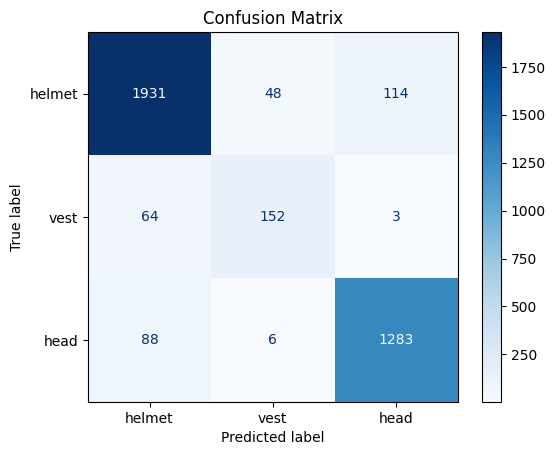


Classification Report:
              precision    recall  f1-score   support

      helmet       0.93      0.92      0.92      2093
        vest       0.74      0.69      0.72       219
        head       0.92      0.93      0.92      1377

    accuracy                           0.91      3689
   macro avg       0.86      0.85      0.85      3689
weighted avg       0.91      0.91      0.91      3689



In [7]:
# Confusion Matrix
if y_true and y_pred:
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
else:
    logging.error("No valid prediction-label pairs to compute metrics.")

In [ ]:
import cv2
import torch
from ultralytics import YOLO

# Load trained YOLO model
model = YOLO(weights_path)  # replace with your trained weights

# Load video
video_path = 0  # or use 0 for webcam
cap = cv2.VideoCapture(video_path)

# Output video settings
output_path = "output_video.mp4"
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv8 inference
    results = model.predict(source=frame, conf=0.25, iou=0.5)

    # Plot detections on the frame
    annotated_frame = results[0].plot()

    # Write to output
    out.write(annotated_frame)

    # Optional: show frame in real-time
    cv2.imshow("YOLOv8 Video", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()